In [1]:
import os
import glob 
import random
import datetime
import pytz
import shutil
from itertools import cycle
from tqdm import tqdm
import gc

# --- Thư viện xử lý dữ liệu và tính toán ---
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE

# --- Thư viện trực quan hóa ---
import seaborn as sns
import matplotlib.pyplot as plt

# --- Thư viện xử lý âm thanh ---
import librosa
import noisereduce as nr
import soundfile as sf
from prep_au import *
import numpy as np
import tensorflow as tf


DATASET_PATH = r"D:\Master Learning_Y1\NCKH\archive"
CLASSES = ["asthma", "covid", "healthy", "tuberculosis"]

d:\Master Learning_Y1\NCKH\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


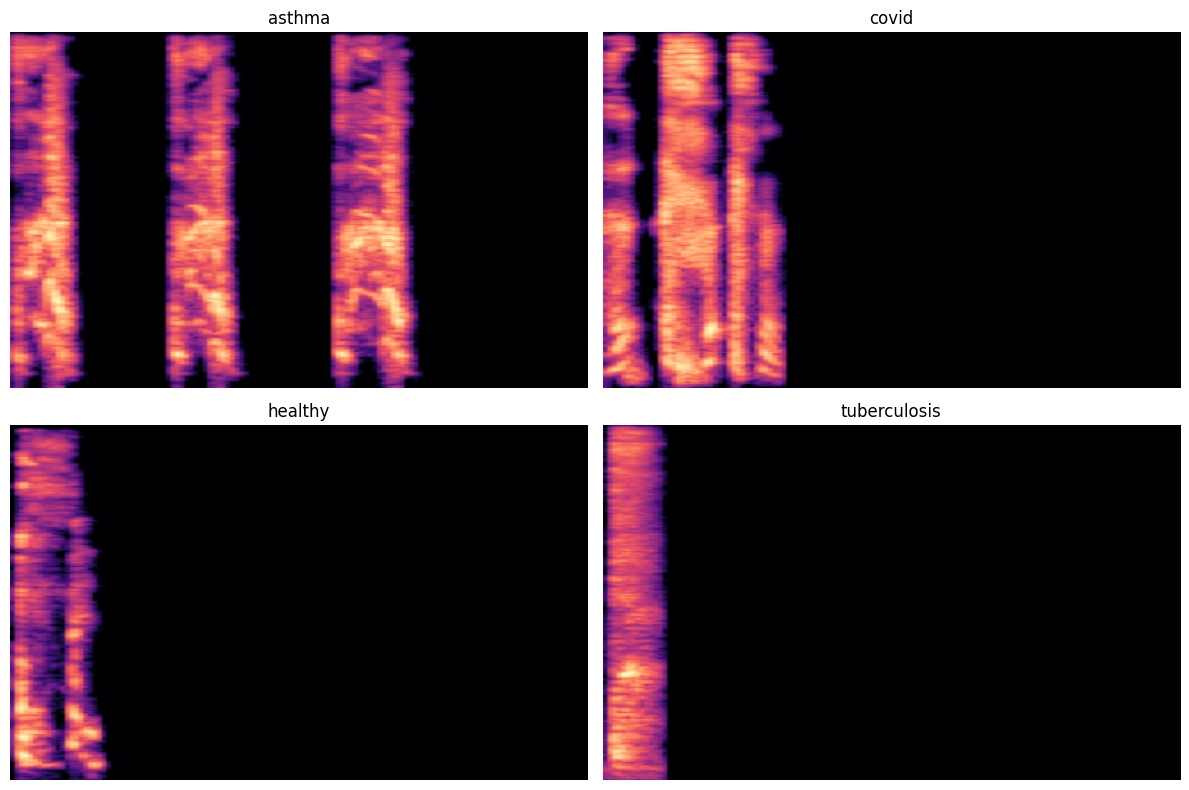

In [2]:
plt.figure(figsize=(12, 8))

for i, cls in enumerate(CLASSES):
    files = [os.path.join(DATASET_PATH, cls, f) for f in os.listdir(os.path.join(DATASET_PATH, cls)) if f.endswith('.npy')]
    f = random.choice(files)
    mel = np.load(f)
    
    plt.subplot(2, 2, i+1)
    plt.imshow(mel, aspect='auto', origin='lower', cmap='magma')
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

# ===============================
# DATA LOADING WITH VALIDATION
# ===============================



def load_and_validate_spectrograms(dataset_path, classes, verbose=True):
    """
    Load spectrograms with validation and size checking.
    
    Returns:
        spectrograms: list of numpy arrays
        labels: numpy array of integer labels
        metadata: dict with useful information
    """
    spectrograms = []
    labels = []
    shapes = []
    corrupted_files = []
    
    for idx, label in enumerate(classes):
        folder = os.path.join(dataset_path, label)
        
        if not os.path.exists(folder):
            print(f"⚠️ Warning: Folder {folder} does not exist!")
            continue
        
        files = [f for f in os.listdir(folder) if f.endswith('.npy')]
        
        if verbose:
            print(f"Loading {label}: {len(files)} files...")
        
        for fname in files:
            fpath = os.path.join(folder, fname)
            try:
                spec = np.load(fpath)
                
                # Validate spectrogram
                if spec.size == 0:
                    corrupted_files.append(fpath)
                    continue
                
                if np.isnan(spec).any() or np.isinf(spec).any():
                    print(f"⚠️ Warning: NaN/Inf values in {fname}")
                    # Option 1: Skip file
                    # corrupted_files.append(fpath)
                    # continue
                    # Option 2: Fix values
                    spec = np.nan_to_num(spec, nan=0.0, posinf=0.0, neginf=0.0)
                
                spectrograms.append(spec)
                labels.append(idx)
                shapes.append(spec.shape)
                
            except Exception as e:
                print(f"❌ Error loading {fname}: {e}")
                corrupted_files.append(fpath)
    
    labels = np.array(labels)
    
    # Metadata
    metadata = {
        'total_samples': len(spectrograms),
        'corrupted_files': corrupted_files,
        'unique_shapes': list(set(shapes)),
        'class_distribution': Counter(labels)
    }
    
    return spectrograms, labels, metadata


# ===============================
# LOAD DATA
# ===============================

spectrograms, labels, metadata = load_and_validate_spectrograms(
    DATASET_PATH, 
    CLASSES, 
    verbose=True
)

print(f"\n{'='*50}")
print(f"✅ Loaded {metadata['total_samples']} samples from {len(CLASSES)} classes")
print(f"{'='*50}")

# ===============================
# DATA ANALYSIS
# ===============================

print("\n📊 Class Distribution:")
for class_idx, count in sorted(metadata['class_distribution'].items()):
    percentage = (count / metadata['total_samples']) * 100
    print(f"  {CLASSES[class_idx]:12s}: {count:4d} samples ({percentage:5.1f}%)")

print(f"\n📐 Unique Spectrogram Shapes:")
for shape in metadata['unique_shapes']:
    count = sum(1 for s in spectrograms if np.array(s).shape == shape)
    print(f"  {shape}: {count} samples")

if metadata['corrupted_files']:
    print(f"\n⚠️ Corrupted files: {len(metadata['corrupted_files'])}")
    for f in metadata['corrupted_files'][:5]:  # Show first 5
        print(f"  - {f}")

# ===============================
# CHECK FOR CLASS IMBALANCE
# ===============================

class_counts = [metadata['class_distribution'][i] for i in range(len(CLASSES))]
imbalance_ratio = max(class_counts) / min(class_counts)

if imbalance_ratio > 2.0:
    print(f"\n⚠️ WARNING: Class imbalance detected! Ratio: {imbalance_ratio:.2f}")
    print("Consider using:")
    print("  - Class weights in model training")
    print("  - Oversampling minority classes")
    print("  - Focal loss")

# ===============================
# HANDLE VARIABLE SIZES
# ===============================

def pad_or_crop_spectrograms(spectrograms, target_shape=None):
    """
    Standardize spectrogram sizes by padding or cropping.
    
    Args:
        spectrograms: list of numpy arrays
        target_shape: tuple (height, width) or None to use max dimensions
    
    Returns:
        numpy array of shape (n_samples, height, width)
    """
    if target_shape is None:
        # Find maximum dimensions
        max_h = max(s.shape[0] for s in spectrograms)
        max_w = max(s.shape[1] for s in spectrograms)
        target_shape = (max_h, max_w)
    
    standardized = []
    target_h, target_w = target_shape
    
    for spec in spectrograms:
        h, w = spec.shape[:2]
        
        # Crop or pad height
        if h > target_h:
            spec = spec[:target_h, :]
        elif h < target_h:
            pad_h = target_h - h
            spec = np.pad(spec, ((0, pad_h), (0, 0)), mode='constant')
        
        # Crop or pad width
        if w > target_w:
            spec = spec[:, :target_w]
        elif w < target_w:
            pad_w = target_w - w
            spec = np.pad(spec, ((0, 0), (0, pad_w)), mode='constant')
        
        standardized.append(spec)
    
    return np.array(standardized, dtype=np.float32)


# Option 1: Pad/crop to common size
print(f"\n🔧 Standardizing spectrogram sizes...")
spectrograms_standardized = pad_or_crop_spectrograms(spectrograms)
print(f"✅ Standardized shape: {spectrograms_standardized.shape}")

# Option 2: If you want to use the preprocessing function that resizes anyway,
# you can keep them as a list and let the preprocessing handle it
# spectrograms_list = spectrograms  # Keep as list

# ===============================
# TRAIN/TEST SPLIT
# ===============================

X_train, X_test, y_train, y_test = train_test_split(
    spectrograms_standardized,  # Now a proper numpy array
    labels,
    test_size=0.3,
    stratify=labels,
    random_state=42
)

print(f"\n{'='*50}")
print(f"📦 Data Split:")
print(f"{'='*50}")
print(f"Train set: {len(X_train)} samples")
print(f"Test set:  {len(X_test)} samples")

# Verify stratification worked
print(f"\n✓ Train class distribution:")
train_dist = Counter(y_train)
for idx, count in sorted(train_dist.items()):
    print(f"  {CLASSES[idx]:12s}: {count:4d} ({count/len(y_train)*100:.1f}%)")

print(f"\n✓ Test class distribution:")
test_dist = Counter(y_test)
for idx, count in sorted(test_dist.items()):
    print(f"  {CLASSES[idx]:12s}: {count:4d} ({count/len(y_test)*100:.1f}%)")

# ===============================
# CALCULATE CLASS WEIGHTS (for training)
# ===============================

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

print(f"\n⚖️ Recommended Class Weights:")
for idx, weight in class_weight_dict.items():
    print(f"  {CLASSES[idx]:12s}: {weight:.3f}")

# ===============================
# SAVE PROCESSED DATA
# ===============================

save_path = "processed_data"
os.makedirs(save_path, exist_ok=True)

np.save(os.path.join(save_path, "X_train.npy"), X_train)
np.save(os.path.join(save_path, "X_test.npy"), X_test)
np.save(os.path.join(save_path, "y_train.npy"), y_train)
np.save(os.path.join(save_path, "y_test.npy"), y_test)
np.save(os.path.join(save_path, "class_weights.npy"), class_weights)

# Save metadata
import json
metadata_save = {
    'classes': CLASSES,
    'class_weight_dict': class_weight_dict,
    'original_shape': spectrograms_standardized.shape[1:],
    'train_size': len(X_train),
    'test_size': len(X_test),
    'class_distribution': {CLASSES[k]: v for k, v in metadata['class_distribution'].items()}
}

with open(os.path.join(save_path, "metadata.json"), 'w') as f:
    json.dump(metadata_save, f, indent=2)

print(f"\n💾 Data saved to: {save_path}/")
print("Files:")
print(f"  - X_train.npy: {X_train.shape}")
print(f"  - X_test.npy: {X_test.shape}")
print(f"  - y_train.npy: {y_train.shape}")
print(f"  - y_test.npy: {y_test.shape}")
print(f"  - class_weights.npy")
print(f"  - metadata.json")

# ===============================
# VISUALIZATION (OPTIONAL)
# ===============================

def visualize_samples(X, y, classes, n_samples=8):
    """Visualize random samples from each class"""
    fig, axes = plt.subplots(len(classes), n_samples // len(classes), 
                             figsize=(15, 10))
    fig.suptitle('Sample Spectrograms from Each Class', fontsize=16)
    
    for idx, class_name in enumerate(classes):
        class_indices = np.where(y == idx)[0]
        samples = np.random.choice(class_indices, 
                                  size=min(2, len(class_indices)), 
                                  replace=False)
        
        for j, sample_idx in enumerate(samples):
            ax = axes[idx, j] if len(classes) > 1 else axes[j]
            ax.imshow(X[sample_idx], aspect='auto', origin='lower', cmap='viridis')
            ax.set_title(f'{class_name}')
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'sample_spectrograms.png'), dpi=150)
    plt.show()
    print(f"\n📊 Visualization saved to: {save_path}/sample_spectrograms.png")

# Uncomment to visualize
# visualize_samples(X_train, y_train, CLASSES, n_samples=8)

print(f"\n✅ Data loading complete!")

Loading asthma: 4613 files...
Loading covid: 10422 files...
Loading healthy: 9492 files...
Loading tuberculosis: 8557 files...

✅ Loaded 33084 samples from 4 classes

📊 Class Distribution:
  asthma      : 4613 samples ( 13.9%)
  covid       : 10422 samples ( 31.5%)
  healthy     : 9492 samples ( 28.7%)
  tuberculosis: 8557 samples ( 25.9%)

📐 Unique Spectrogram Shapes:
  (256, 126): 33084 samples

⚠️ WARNING: Class imbalance detected! Ratio: 2.26
Consider using:
  - Class weights in model training
  - Oversampling minority classes
  - Focal loss

🔧 Standardizing spectrogram sizes...
✅ Standardized shape: (33084, 256, 126)

📦 Data Split:
Train set: 23158 samples
Test set:  9926 samples

✓ Train class distribution:
  asthma      : 3229 (13.9%)
  covid       : 7295 (31.5%)
  healthy     : 6644 (28.7%)
  tuberculosis: 5990 (25.9%)

✓ Test class distribution:
  asthma      : 1384 (13.9%)
  covid       : 3127 (31.5%)
  healthy     : 2848 (28.7%)
  tuberculosis: 2567 (25.9%)

⚖️ Recommended C

In [3]:
from prep_au import create_augmentation_pipeline

# Load lại
X_train = np.load(r"D:\Master Learning_Y1\NCKH\processing\processed_data\X_train.npy", allow_pickle=True)
X_test = np.load(r"D:\Master Learning_Y1\NCKH\processing\processed_data\X_test.npy", allow_pickle=True)
y_train = np.load(r"D:\Master Learning_Y1\NCKH\processing\processed_data\y_train.npy")
y_test = np.load(r"D:\Master Learning_Y1\NCKH\processing\processed_data\y_test.npy")

# Tạo dataset
train_ds = create_augmentation_pipeline(X_train, y_train, batch_size=32, is_training=True)
test_ds = create_augmentation_pipeline(X_test, y_test, batch_size=32, is_training=False)


In [5]:
import json

In [6]:
DATA_PATH = r"D:\Master Learning_Y1\NCKH\processing\processed_data"

X_train = np.load(os.path.join(DATA_PATH, "X_train.npy"))
X_test = np.load(os.path.join(DATA_PATH, "X_test.npy"))
y_train = np.load(os.path.join(DATA_PATH, "y_train.npy"))
y_test = np.load(os.path.join(DATA_PATH, "y_test.npy"))

with open(os.path.join(DATA_PATH, "metadata.json"), "r") as f:
    metadata = json.load(f)

CLASSES = metadata["classes"]
NUM_CLASSES = len(CLASSES)
print("✅ Loaded data:", X_train.shape, X_test.shape)

✅ Loaded data: (23158, 256, 126) (9926, 256, 126)
